In [1]:
%matplotlib inline

In [2]:
import adolc

In [3]:
from adapt_utils.case_studies.tohoku.options.okada_options import TohokuOkadaBasisOptions
from adapt_utils.optimisation import taylor_test
from adapt_utils.norms import vecnorm

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

In [5]:
np.random.seed(0)  # make results reproducible

In [6]:
def use_degrees(axes, x=True, y=True):
    if x:
        xlim = axes.get_xlim()
        axes.set_xticks(axes.get_xticks())
        axes.set_xticklabels([r"${:.0f}^\circ$".format(tick) for tick in axes.get_xticks()])
        axes.set_xlim(xlim)
    if y:
        ylim = axes.get_ylim()
        axes.set_yticks(axes.get_yticks())
        axes.set_yticklabels([r"${:.0f}^\circ$".format(tick) for tick in axes.get_yticks()])
        axes.set_ylim(ylim)

In [7]:
def use_percent(axes, x=True, y=True):
    if x:
        xlim = axes.get_xlim()
        axes.set_xticks(axes.get_xticks())
        axes.set_xticklabels([r"{:.0f}\%".format(tick) for tick in axes.get_xticks()])
        axes.set_xlim(xlim)
    if y:
        ylim = axes.get_ylim()
        axes.set_yticks(axes.get_yticks())
        axes.set_yticklabels([r"{:.0f}\%".format(tick) for tick in axes.get_yticks()])
        axes.set_ylim(ylim)

# Inverting the Okada model for slip and rake only

The experiments in this notebook are very much the same as those in the previous one.
The only difference is that strike and dip are fixed at $198^\circ$ and $10^\circ$, respectively.

### Initialisation

Set parameters and create a `TohokuOkadaBasisOptions` object to hold them.
Apply the Okada model with default input parameters to give the field we want to invert for, stored in memory as `eta`.

In [8]:
kwargs = {
    'okada_grid_resolution': 51,
    'okada_grid_lon_min': 140,
    'okada_grid_lon_max': 145,
    'okada_grid_lat_min': 35,
    'okada_grid_lat_max': 41,
    'debug': False,
}
active_controls = ['slip', 'rake']

In [9]:
plotting_kwargs = dict(cmap='coolwarm', levels=50)
fontsize = 30
tick_fontsize = 26

In [10]:
op = TohokuOkadaBasisOptions(**kwargs)
op.active_controls = active_controls
op.create_topography()
N = op.N
X = op.fault.dtopo.X
Y = op.fault.dtopo.Y
eta = op.fault.dtopo.dZ.copy()
m_orig = op.input_vector.copy()

In [11]:
np.save("notebook_6_m_orig.npy", m_orig)

### Differentatiate the source model

Perturb the control parameters with some Normal random noise so that the source is different from that used to generate the gauge timeseries data.
This effectively means 'choose an initial guess'.

In [12]:
kwargs['control_parameters'] = op.control_parameters
for control in op.active_controls:
    size = np.shape(op.control_parameters[control])
    std = np.std(op.control_parameters[control])
    kwargs['control_parameters'][control] += np.random.normal(loc=0, scale=std/2, size=size)

In [13]:
kwargs['control_parameters']['slip'] = np.abs(kwargs['control_parameters']['slip'])
for i, rake in enumerate(kwargs['control_parameters']['rake']):
    kwargs['control_parameters']['rake'][i] = rake % 90

When setting the free surface initial condition using the Okada model, we tell `pyadolc` to annotate its tape.
For this application we need to modify the way that the tape is annotated by default and therefore pass the `interpolate` flag as `True`:

In [14]:
tape_tag = 0
op = TohokuOkadaBasisOptions(**kwargs)
op._data_to_interpolate = eta
op.active_controls = active_controls
op.create_topography(annotate=True, interpolate=True, tag=tape_tag)
print("QoI = {:.4e}".format(op.J.val))
assert np.isclose(op.J.val, 3.5062e+00, rtol=1.0e-04)  # from previous run

QoI = 3.5062e+00


Create some arrays to keep track of the optimisation routine

In [15]:
op.J_progress = []
op.dJdm_progress = []

Sum over all subfaults to get the total QoI.
By unrolling the tape, we can easily express the reduced functional as a function of the active controls.
Note that we raise a flag which prepares for a subsequent reverse mode propagation.

In [16]:
def reduced_functional(m):
    """
    Apply the Okada model by unrolling the tape and compute the QoI.
    """
    J = sum(adolc.zos_forward(tape_tag, m, keep=1))
    op.J_progress.append(J)
    return J

In [17]:
J = reduced_functional(op.input_vector)
assert np.isclose(J, op.J.val)

The reverse mode of AD computes

$$
    \mathbf m_b:=\frac{\mathrm dJ}{\mathrm d\mathbf m}^T\:J_b,
$$

where $J_b$ is a scalar *seed* and $\mathbf m_b$ is of the same dimension as the control parameter vector.
Therefore we can propagate through the reverse mode of AD to get the gradient by choosing a unit seed.

In [18]:
def gradient(m):
    """
    Compute the gradient of the QoI with respect to the input parameters.
    """
    dJdm = adolc.fos_reverse(tape_tag, 1.0)
    op.dJdm_progress.append(vecnorm(dJdm, order=np.Inf))
    return dJdm

In [19]:
g = gradient(op.input_vector)
assert len(g) == len(op.input_vector)
print("J = {:.4e}  ||dJdm|| = {:.4e}".format(op.J_progress[-1], op.dJdm_progress[-1]))
assert np.isclose(op.dJdm_progress[-1], 1.1288e-02, rtol=1.0e-04)  # from previous run

J = 3.5062e+00  ||dJdm|| = 1.1288e-02


In [20]:
eta_pert = op.fault.dtopo.dZ.copy()
eta_pert = op.fault.dtopo.dZ.reshape(N, N)

Check that the function stored to tape evaluates as it should

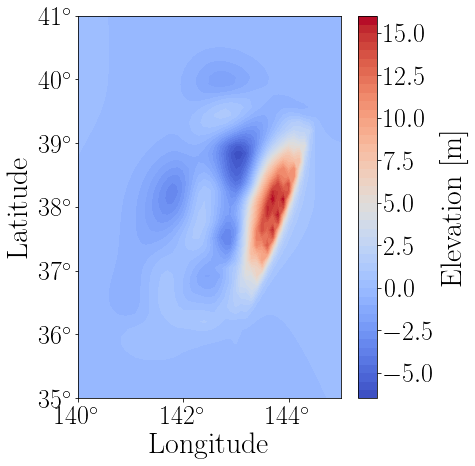

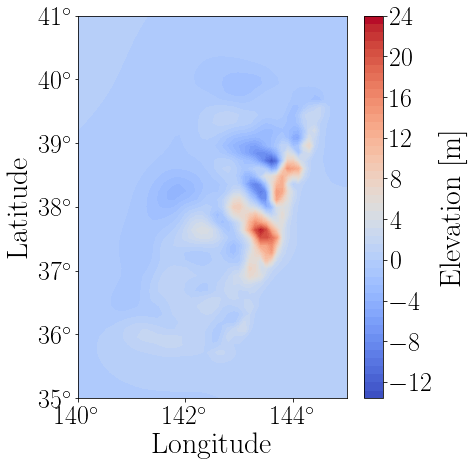

In [21]:
fig, axes = plt.subplots(figsize=(7, 7))
cbar = fig.colorbar(axes.contourf(X, Y, eta, **plotting_kwargs), ax=axes);
cbar.set_label(r"Elevation [$\mathrm m$]", fontsize=fontsize)
cbar.ax.tick_params(labelsize=tick_fontsize);
axes.set_xlabel("Longitude", fontsize=fontsize);
axes.set_ylabel("Latitude", fontsize=fontsize);
use_degrees(axes)
for tick in axes.xaxis.get_major_ticks():
    tick.label.set_fontsize(tick_fontsize);
for tick in axes.yaxis.get_major_ticks():
    tick.label.set_fontsize(tick_fontsize);
plt.tight_layout()
plt.savefig("plots/notebook_6_original_source.jpg")

fig, axes = plt.subplots(figsize=(7, 7))
cbar = fig.colorbar(axes.contourf(X, Y, eta_pert, **plotting_kwargs), ax=axes);
cbar.ax.tick_params(labelsize=tick_fontsize);
cbar.set_label(r"Elevation [$\mathrm m$]", fontsize=fontsize)
axes.set_xlabel("Longitude", fontsize=fontsize);
axes.set_ylabel("Latitude", fontsize=fontsize);
use_degrees(axes)
for tick in axes.xaxis.get_major_ticks():
    tick.label.set_fontsize(tick_fontsize);
for tick in axes.yaxis.get_major_ticks():
    tick.label.set_fontsize(tick_fontsize);
plt.tight_layout()
plt.savefig("plots/notebook_6_perturbed_source.jpg")

### Taylor test

Before attempting gradient-based optimisation, we better check that our gradient function is consistent.

In [22]:
taylor_test(reduced_functional, gradient, op.input_vector, verbose=True)

========================TAYLOR TEST========================
h = 1.0000e-02
remainder = 7.2602e-07
h = 5.0000e-03
remainder = 1.8151e-07  convergence rate = 2.00
h = 2.5000e-03
remainder = 4.5376e-08  convergence rate = 2.00
h = 1.2500e-03
remainder = 1.1344e-08  convergence rate = 2.00
====================TAYLOR TEST PASSED!====================


1.999996103295699

### Inversion

Now we are ready to do the gradient-based optimisation.
Here we use BFGS and require that the gradient norm is smaller than $10^{-8}$ for convergence.

In [23]:
# Reset progress arrays
op.J_progress = []
op.dJdm_progress = []

def opt_cb(m):
    """
    Print progress after every successful line search.
    """
    msg = "{:4d}: J = {:.4e}  ||dJdm|| = {:.4e}"
    counter = len(op.J_progress)
    if counter % 100 == 0:
        print(msg.format(counter, op.J_progress[-1], op.dJdm_progress[-1]))

bounds = [bound for subfault in op.subfaults for bound in [(0, np.Inf), (0, 90)]]
opt_parameters = {
    'maxiter': 40000,
    'disp': True,
    'pgtol': 1.0e-08,
    'callback': opt_cb,
    'bounds': bounds,
    'fprime': gradient,
}

m_opt, J_opt, out = scipy.optimize.fmin_l_bfgs_b(reduced_functional, op.input_vector, **opt_parameters)

 100: J = 1.3840e-03  ||dJdm|| = 2.5152e-05
 200: J = 6.5137e-04  ||dJdm|| = 1.3806e-05
 300: J = 2.4120e-04  ||dJdm|| = 1.3447e-05
 400: J = 1.6413e-04  ||dJdm|| = 7.2830e-06
 500: J = 1.2438e-04  ||dJdm|| = 7.2058e-06
 600: J = 1.0627e-04  ||dJdm|| = 5.6744e-06
 700: J = 6.1443e-05  ||dJdm|| = 5.9352e-06
 800: J = 4.9022e-05  ||dJdm|| = 5.1289e-06
 900: J = 4.2295e-05  ||dJdm|| = 4.8416e-06
1000: J = 3.8757e-05  ||dJdm|| = 6.1468e-06
1100: J = 3.6524e-05  ||dJdm|| = 6.0623e-06
1200: J = 3.3081e-05  ||dJdm|| = 5.3682e-06
1300: J = 2.8399e-05  ||dJdm|| = 5.4743e-06
1400: J = 2.4880e-05  ||dJdm|| = 4.4711e-06
1500: J = 2.1848e-05  ||dJdm|| = 3.1488e-06
1600: J = 1.4602e-05  ||dJdm|| = 1.9027e-06
1700: J = 7.2018e-06  ||dJdm|| = 6.3300e-07
1800: J = 5.3701e-06  ||dJdm|| = 4.6632e-07
1900: J = 3.6413e-06  ||dJdm|| = 8.1206e-07
2000: J = 2.7237e-06  ||dJdm|| = 2.0474e-07


In [24]:
np.save("notebook_6_m_opt.npy", m_opt)
np.save("notebook_6_J_progress.npy", op.J_progress)
np.save("notebook_6_dJdm_progress.npy", op.dJdm_progress)

Let's take a look at the progress of the reduced functional and gradient

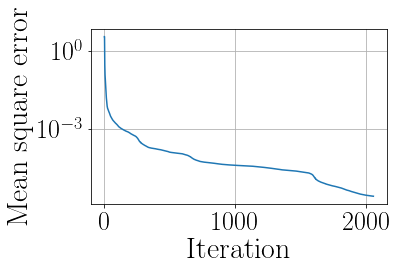

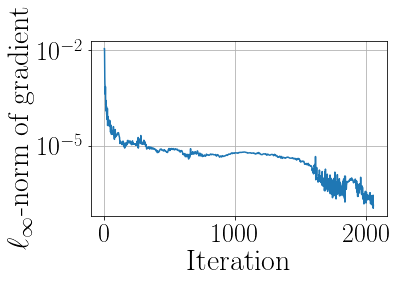

In [25]:
op.J_progress = np.load("notebook_6_J_progress.npy")
op.dJdm_progress = np.load("notebook_6_dJdm_progress.npy")

fig, axes = plt.subplots()
axes.semilogy(op.J_progress);
axes.set_xlabel("Iteration", fontsize=fontsize);
axes.set_ylabel("Mean square error", fontsize=fontsize);
for tick in axes.xaxis.get_major_ticks():
    tick.label.set_fontsize(tick_fontsize);
for tick in axes.yaxis.get_major_ticks():
    tick.label.set_fontsize(tick_fontsize);
axes.grid(True);
plt.tight_layout()
plt.savefig("plots/notebook_6_J_progress.pdf")

fig, axes = plt.subplots()
axes.semilogy(op.dJdm_progress);
axes.set_xlabel("Iteration", fontsize=fontsize);
axes.set_ylabel(r"$\ell_\infty$-norm of gradient", fontsize=fontsize);
for tick in axes.xaxis.get_major_ticks():
    tick.label.set_fontsize(tick_fontsize);
for tick in axes.yaxis.get_major_ticks():
    tick.label.set_fontsize(tick_fontsize);
axes.grid(True);
plt.tight_layout()
plt.savefig("plots/notebook_6_dJdm_progress.pdf")

Compare the optimised parameters, `m_opt`, against the original ones, `m_orig`.

In [11]:
m_opt = np.load("notebook_6_m_opt.npy")
m_orig = np.load("notebook_6_m_orig.npy")
diff = m_opt - m_orig
print("Mean square error of controls = {:.4e}".format(np.linalg.norm(diff)**2/len(m_opt)))

Mean square error of controls = 1.0234e+02


In [12]:
diff = diff.reshape(op.nx*op.ny, len(op.active_controls))
m_orig = m_orig.reshape(op.nx*op.ny, len(op.active_controls))
m_opt = m_opt.reshape(op.nx*op.ny, len(op.active_controls))

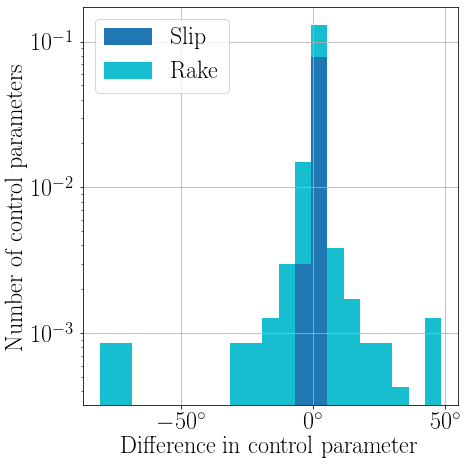

In [13]:
fig, axes = plt.subplots(figsize=(7, 7))
labels = [control.capitalize() for control in op.active_controls]
colours = ['C0', 'C9']
axes.hist(diff, bins=21, histtype='bar', density=True, stacked=True, label=labels, color=colours);
plt.yscale('log');
use_degrees(axes, x=True, y=False)
axes.set_xlabel("Difference in control parameter");
axes.set_ylabel("Number of control parameters");
axes.grid(True)
axes.legend()
plt.tight_layout()
plt.savefig("plots/notebook_6_histogram.pdf")

In [14]:
# for j, row in enumerate(diff):
#     print("{:3d}: {:8.4f}, {:8.4f}".format(j, *row))

In [15]:
msg = "Maximum pointwise difference: {:.4f} degree difference in {:s} on subfault {:d}"
loc = np.unravel_index(np.argmax(np.abs(diff), axis=None), diff.shape)
print(msg.format(diff[loc], op.active_controls[loc[1]], loc[0]))

Maximum pointwise difference: -81.0470 degree difference in rake on subfault 118


In [16]:
rel_diff = diff.copy()
rel_diff[:, 0] /= np.abs(m_orig[:, 0].max())
rel_diff[:, 1] /= np.abs(m_orig[:, 1].max())
rel_diff *= 100

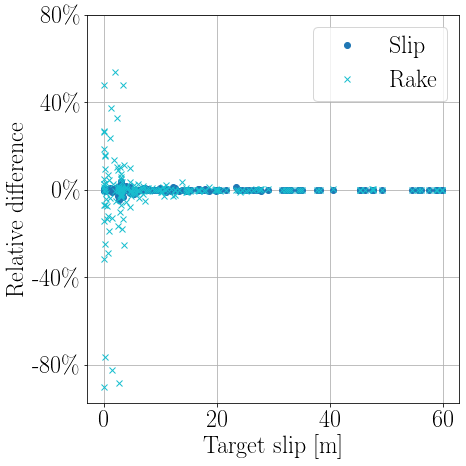

In [19]:
fig, axes = plt.subplots(figsize=(7, 7))
colours = ['C0', 'C9']
markers = ['o', 'x']
for i, (control, colour, marker) in enumerate(zip(op.active_controls, colours, markers)):
    axes.plot(m_orig[:, 0], rel_diff[:, i], marker, label=control.capitalize(), color=colour)
axes.grid(True);
axes.set_xlabel("Target slip [$\mathrm m$]")
axes.set_ylabel("Relative difference")
axes.set_yticks([-80, -40, 0, 40, 80])
use_percent(axes, x=False, y=True)

axes.legend()
plt.tight_layout()
plt.savefig("plots/notebook_6_slip_vs_diff.pdf")

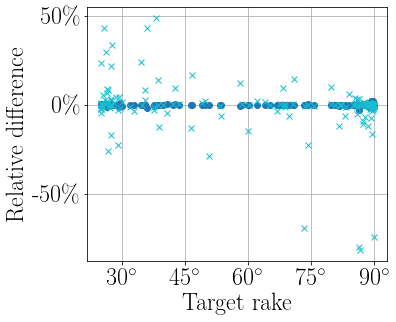

In [33]:
fig, axes = plt.subplots(figsize=(6, 5))
colours = ['C0', 'C9']
markers = ['o', 'x']
for i, (control, colour, marker) in enumerate(zip(op.active_controls, colours, markers)):
    axes.plot(m_orig[:, 1], diff[:, i], marker, label=control.capitalize(), color=colour)
axes.grid(True);
axes.set_xlabel("Target rake")
axes.set_ylabel("Relative difference")
axes.set_xticks([30, 45, 60, 75, 90])
use_percent(axes, x=False, y=True)
use_degrees(axes, x=True, y=False)
# axes.legend()
plt.tight_layout()
plt.savefig("plots/notebook_6_rake_vs_diff.pdf")

In [34]:
m_opt = np.load("notebook_6_m_opt.npy")
m_opt = m_opt.reshape(op.nx*op.ny, len(op.active_controls))
for i, control in enumerate(op.active_controls):
    kwargs['control_parameters'][control] = m_opt[:, i]

In [35]:
# kwargs['control_parameters']['slip'] = kwargs['control_parameters']['Slip']
# kwargs['control_parameters']['rake'] = kwargs['control_parameters']['Rake']

In [36]:
op = TohokuOkadaBasisOptions(**kwargs)
op.active_controls = active_controls
op.create_topography()

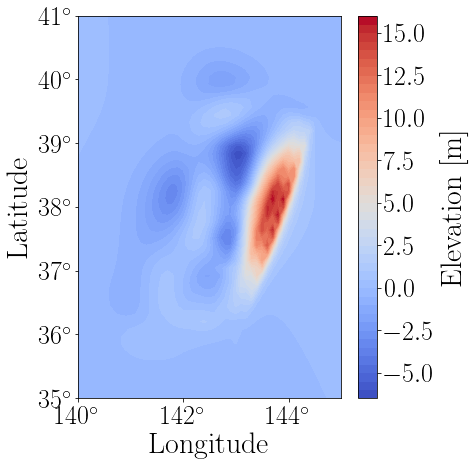

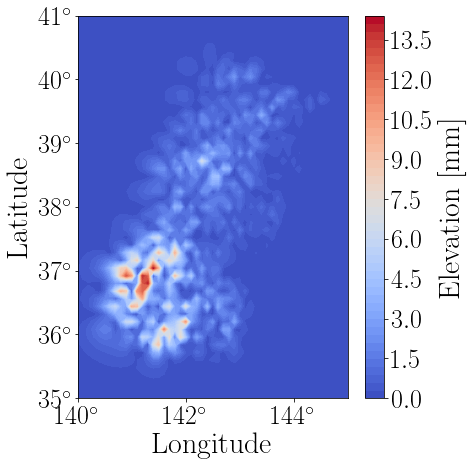

In [37]:
eta_opt = op.fault.dtopo.dZ.reshape(N, N)
eta_err = np.abs(eta - eta_opt)*1000

fig, axes = plt.subplots(figsize=(7, 7))
cbar = fig.colorbar(axes.contourf(X, Y, eta_opt, **plotting_kwargs), ax=axes);
cbar.ax.tick_params(labelsize=tick_fontsize);
cbar.set_label(r'Elevation [$\mathrm m$]', size=fontsize);
axes.set_xlabel("Longitude", fontsize=fontsize);
axes.set_ylabel("Latitude", fontsize=fontsize);
use_degrees(axes)
for tick in axes.xaxis.get_major_ticks():
    tick.label.set_fontsize(tick_fontsize);
for tick in axes.yaxis.get_major_ticks():
    tick.label.set_fontsize(tick_fontsize);
plt.tight_layout()
plt.savefig("plots/notebook_6_optimised_source.jpg")

fig, axes = plt.subplots(figsize=(7, 7))
cbar = fig.colorbar(axes.contourf(X, Y, eta_err, **plotting_kwargs), ax=axes);
cbar.ax.tick_params(labelsize=tick_fontsize);
cbar.set_label(r'Elevation [$\mathrm{mm}$]', size=fontsize);
axes.set_xlabel("Longitude", fontsize=fontsize);
axes.set_ylabel("Latitude", fontsize=fontsize);
use_degrees(axes)
for tick in axes.xaxis.get_major_ticks():
    tick.label.set_fontsize(tick_fontsize);
for tick in axes.yaxis.get_major_ticks():
    tick.label.set_fontsize(tick_fontsize);
plt.tight_layout()
plt.savefig("plots/notebook_6_pointwise_error.jpg")